# Data Exploration of Stock Returns and SEC Forms Data
12.6.17  

### Read in stock data

In [31]:
import seaborn as sns, numpy as np
import csv, matplotlib.pyplot as plt
filename = 'data/Stock_Returns/Original/stocks.csv'
# filename = 'data/Stock_Returns/SPY.csv'

In [32]:
"""
skip = 0 # SPY.csv
skip = 1 # Original/stocks.csv
"""
def find_cumulative_returns(filename='stocks.csv', timeframe=9, skip=1):
    rows = []
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        for row in csvreader:
            rows.append(row)
    cumulative_returns = [1] * len(rows)
    for start in range(len(rows)):
        # skip first row
        if (skip):
            skip = 0
            continue
        for offset in range(timeframe):
            if (start+offset >= len(rows)):
                break
            multiplier = 1+float(rows[start+offset][2])
            cumulative_returns[start] *= multiplier
    return cumulative_returns

In [33]:
cumulative_returns = find_cumulative_returns(filename=filename, timeframe=9, skip=1)

In [34]:
cumulative_returns = [np.log2(x) for x in cumulative_returns[:10000]]

## Distribution of cumulative returns in 9-day timeframes
Log-returns look pretty symmetrical

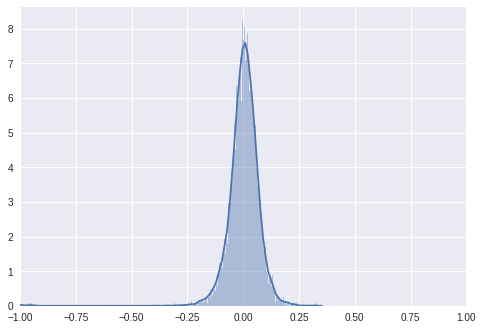

In [35]:
sns.set();
ax = sns.distplot(np.array(cumulative_returns), bins=500)
ax.set_xlim(-1,1)
plt.show()

In [36]:
cumulative_returns = find_cumulative_returns(filename=filename, timeframe=9, skip=1)

In [37]:
cumulative_returns = [np.log2(x) for x in cumulative_returns[:10000]]

## Distribution of cumulative returns in 30-day timeframes
Log-returns look pretty similar

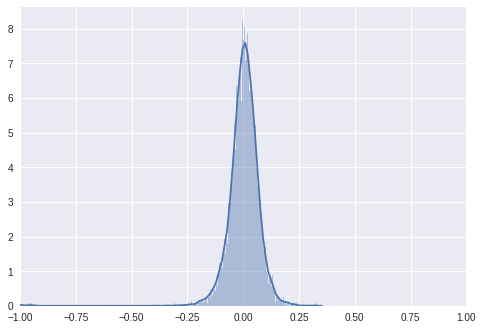

In [38]:
sns.set();
ax = sns.distplot(np.array(cumulative_returns[:10000]), bins=500)
ax.set_xlim(-1,1)
plt.show()

In [39]:
cumulative_returns = find_cumulative_returns(filename=filename, timeframe=9, skip=1)

In [40]:
cumulative_returns = [np.log2(x) for x in cumulative_returns[:10000]]

## Distribution of cumulative returns in 4-day timeframes
Log-returns 

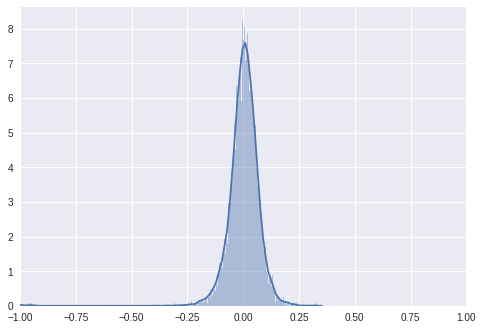

In [41]:
sns.set();
ax = sns.distplot(np.array(cumulative_returns[:10000]), bins=500)
ax.set_xlim(-1,1)
plt.show()

In [45]:
neg = 0
pos = 0
for ret in cumulative_returns:
    if ret <= 0:
        neg+=1
    else:
        pos+=1
print("neg: {} pos: {}".format(neg, pos))

neg: 4531 pos: 5469


Looks like there's more area on the right side during this timeframe (first 10k rows)

## What do these distributions look like around SEC Form releases?

In [137]:
import sqlite3
import glob
import re
import getReturns

import datetime
import time

conn = sqlite3.connect('Database/stocks.db')
form10KPath = '../GROUP_SHARED/data/10K/10-X_C/'
cikTickerPath = '../GROUP_SHARED/data/10K/10-X_C/cikTicker.txt'
with open(cikTickerPath) as cikfile:
    cikTicker = cikfile.read()  
cikTicker = cikTicker.replace('\n', '')
cikTicker = cikTicker.replace('"', '')
cikTicker = cikTicker.replace('"', '')
cikTicker = cikTicker[2:-2].split('}, {')
cikdict = dict(s.split(', ') for s in cikTicker)

def dateSubtract(date, amount):
    date = datetime.datetime.strptime(date, '%Y-%m-%d')
    date = date - datetime.timedelta(days=4)
    date = date.strftime('%Y-%m-%d')
    return date

def parseTxtName(txt):
    txt = os.path.basename(txt)
    pattern = "edgar_data_(.*?)_"
    m = re.search(pattern, txt)
    if m:
        cik = m.group(1)
    pattern = "(\d{8})_"
    m = re.search(pattern, txt)
    if m:
        date = m.group(1)
    date = '{}-{}-{}'.format(date[0:4], date[4:6], date[6:])
    return cik, date

def isPos(txt, cikdict, mode): 
    cik, date = parseTxtName(txt)
    if cik in cikdict:
        if (mode == 0):
            ret = getReturns.getRets(conn, cikdict[cik], date, 4) 
        elif (mode == 1):
            ret = getReturns.getTotalRet(conn, cikdict[cik], date, 30)
        elif (mode == 2):
            stock_ret = getReturns.getTotalRet(conn, cikdict[cik], dateSubtract(date, 4), 9)
            spy_ret = getReturns.getTotalRet(conn, 'SPY', dateSubtract(date, 4), 9)
            alpha = getReturns.getRets(conn, cikdict[cik], date)[0][3]
            ret = stock_ret - spy_ret * alpha
        elif (mode == 3):
            stock_ret = getReturns.getTotalRet(conn, cikdict[cik], dateSubtract(date, 4), 4)
            spy_ret = getReturns.getTotalRet(conn, 'SPY', dateSubtract(date, 4), 4)
            alpha = getReturns.getRets(conn, cikdict[cik], date)[0][3]
            ret = stock_ret - spy_ret * alpha
        elif (mode == 4):
            stock_ret = getReturns.getTotalRet(conn, cikdict[cik], date, 5)
            spy_ret = getReturns.getTotalRet(conn, 'SPY', date, 5)
            alpha = getReturns.getRets(conn, cikdict[cik], date)[0][3]
            ret = stock_ret - spy_ret * alpha
    else:
        raise Exception('Not in cikDict')
    if (mode == 0):
        if (len(ret) != 0): 
            return(np.sign(ret[0][3])==1.0)
        else:            
            raise Exception('Query failed')
    elif (mode == 1):
        if (ret == 0.0):
            return 0
        elif (ret < -1.0):
            return -2
        elif (ret < -0.05):
            return -1
        elif (ret < 0.05):
            return 1
        elif (ret < 1.0):
            return 2
        else:
            return 3
    elif (mode == 2 or mode == 3 or mode == 4):
        if (ret == 0.0):
            return 0
        elif (ret < np.log2(0.975)):
            return -2
        elif (ret < np.log2(0.995)):
            return -1
        elif (ret < np.log2(1.005)):
            return 1
        elif (ret < np.log2(1.025)):
            return 2
        else:
            return 3

In [138]:
"""
quarters = ['2013/QTR2', '2013/QTR3', '2013/QTR4', 
            '2012/QTR1', '2012/QTR2', '2012/QTR3', '2012/QTR4', 
            '2011/QTR1', '2011/QTR2', '2011/QTR3', '2011/QTR4', 
            '2010/QTR1', '2010/QTR2', '2010/QTR3', '2010/QTR4', 
            '2009/QTR1', '2009/QTR2', '2009/QTR3', '2009/QTR4', 
            '2008/QTR1', '2008/QTR2', '2008/QTR3', '2008/QTR4', 
            '2007/QTR1', '2007/QTR2', '2007/QTR3', '2007/QTR4', 
            '2006/QTR1', '2006/QTR2', '2006/QTR3', '2006/QTR4', 
            '2005/QTR1', '2005/QTR2', '2005/QTR3', '2005/QTR4', 
            '2004/QTR1', '2004/QTR2', '2004/QTR3', '2004/QTR4', 
            '2003/QTR1', '2003/QTR2', '2003/QTR3', '2003/QTR4', 
            '2002/QTR1', '2002/QTR2', '2002/QTR3', '2002/QTR4', 
            '2001/QTR1', '2001/QTR2', '2001/QTR3', '2001/QTR4', 
            '2000/QTR1', '2000/QTR2', '2000/QTR3', '2000/QTR4', 
            '1999/QTR1', '1999/QTR2', '1999/QTR3', '1999/QTR4', 
            '1998/QTR1', '1998/QTR2', '1998/QTR3', '1998/QTR4', 
            '1997/QTR1', '1997/QTR2', '1997/QTR3', '1997/QTR4', 
            '1996/QTR1', '1996/QTR2', '1996/QTR3', '1996/QTR4', 
            '1995/QTR1', '1995/QTR2', '1995/QTR3', '1995/QTR4',
            '1994/QTR1', '1994/QTR2', '1994/QTR3', '1994/QTR4']
"""
import os.path
mode = 2
quarters = ['2012/QTR1']
pos = 0
neg = 0
unsupervised = 0
unmapped = 0
neutral = 0
very_pos = 0
very_neg = 0
for quarter in quarters:
    dirname = os.path.join(form10KPath, quarter)
    txt_files = glob.glob(os.path.join(dirname, '*.txt'))
    for txt in txt_files:
        try:
            result = isPos(txt, cikdict, mode)
            if (result == 0):
                unsupervised+=1
            elif (result == 2):
                pos+=1
            elif (result == 3):
                very_pos+=1
            elif (result == 1):
                neutral += 1
            elif (result == -1):
                neg+=1
            elif (result == -2):
                very_neg+=1
        except Exception as ex:
            unmapped += 1
            #print(ex)
            continue

In [139]:
print("unsupervised: {} neutral: {} neg: {} pos: {} very_neg: {} very_pos: {}".format(unsupervised, neutral, neg, pos, very_neg, very_pos))

unsupervised: 1 neutral: 226 neg: 341 pos: 340 very_neg: 274 very_pos: 408


In [140]:
sentiment_distribution = [very_neg, neg, neutral, pos, very_pos]

## Distribution of returns in a 9-day window around SEC Form releases
Hmm! Surprising to see a peak at very positive returns

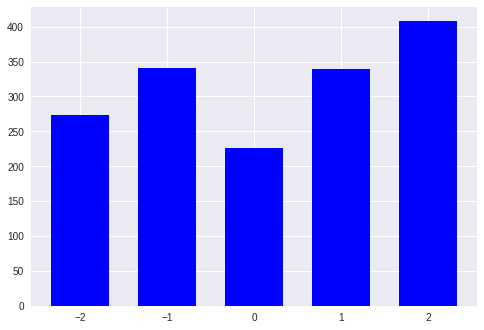

In [141]:
N = len(sentiment_distribution)
x = range(-2, 3)
width = 1/1.5
plt.bar(x, sentiment_distribution, width, color="blue")
window_dist = sentiment_distribution
plt.show()

In [142]:
"""
quarters = ['2013/QTR2', '2013/QTR3', '2013/QTR4', 
            '2012/QTR1', '2012/QTR2', '2012/QTR3', '2012/QTR4', 
            '2011/QTR1', '2011/QTR2', '2011/QTR3', '2011/QTR4', 
            '2010/QTR1', '2010/QTR2', '2010/QTR3', '2010/QTR4', 
            '2009/QTR1', '2009/QTR2', '2009/QTR3', '2009/QTR4', 
            '2008/QTR1', '2008/QTR2', '2008/QTR3', '2008/QTR4', 
            '2007/QTR1', '2007/QTR2', '2007/QTR3', '2007/QTR4', 
            '2006/QTR1', '2006/QTR2', '2006/QTR3', '2006/QTR4', 
            '2005/QTR1', '2005/QTR2', '2005/QTR3', '2005/QTR4', 
            '2004/QTR1', '2004/QTR2', '2004/QTR3', '2004/QTR4', 
            '2003/QTR1', '2003/QTR2', '2003/QTR3', '2003/QTR4', 
            '2002/QTR1', '2002/QTR2', '2002/QTR3', '2002/QTR4', 
            '2001/QTR1', '2001/QTR2', '2001/QTR3', '2001/QTR4', 
            '2000/QTR1', '2000/QTR2', '2000/QTR3', '2000/QTR4', 
            '1999/QTR1', '1999/QTR2', '1999/QTR3', '1999/QTR4', 
            '1998/QTR1', '1998/QTR2', '1998/QTR3', '1998/QTR4', 
            '1997/QTR1', '1997/QTR2', '1997/QTR3', '1997/QTR4', 
            '1996/QTR1', '1996/QTR2', '1996/QTR3', '1996/QTR4', 
            '1995/QTR1', '1995/QTR2', '1995/QTR3', '1995/QTR4',
            '1994/QTR1', '1994/QTR2', '1994/QTR3', '1994/QTR4']
"""
import os.path
mode = 3
quarters = ['2012/QTR1']
pos = 0
neg = 0
unsupervised = 0
unmapped = 0
neutral = 0
very_pos = 0
very_neg = 0
for quarter in quarters:
    dirname = os.path.join(form10KPath, quarter)
    txt_files = glob.glob(os.path.join(dirname, '*.txt'))
    for txt in txt_files:
        try:
            result = isPos(txt, cikdict, mode)
            if (result == 0):
                unsupervised+=1
            elif (result == 2):
                pos+=1
            elif (result == 3):
                very_pos+=1
            elif (result == 1):
                neutral += 1
            elif (result == -1):
                neg+=1
            elif (result == -2):
                very_neg+=1
        except Exception as ex:
            unmapped += 1
            continue

In [143]:
print("unsupervised: {} neutral: {} neg: {} pos: {} very_neg: {} very_pos: {}".format(unsupervised, neutral, neg, pos, very_neg, very_pos))

unsupervised: 14 neutral: 405 neg: 393 pos: 417 very_neg: 145 very_pos: 216


In [144]:
sentiment_distribution = [very_neg, neg, neutral, pos, very_pos]

## Distribution of returns in a 4 days before until the SEC Form release (not inclusive)
This is the symmetrical distribution I expect

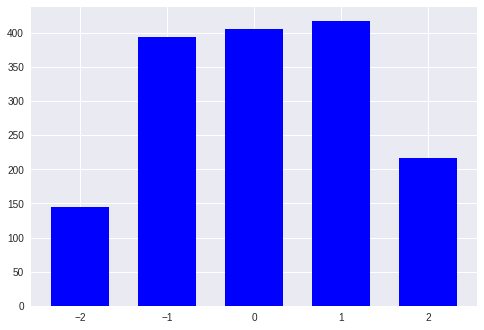

In [145]:
N = len(sentiment_distribution)
x = range(-2, 3)
width = 1/1.5
plt.bar(x, sentiment_distribution, width, color="blue")
pre_dist = sentiment_distribution
plt.show()

In [146]:
"""
quarters = ['2013/QTR2', '2013/QTR3', '2013/QTR4', 
            '2012/QTR1', '2012/QTR2', '2012/QTR3', '2012/QTR4', 
            '2011/QTR1', '2011/QTR2', '2011/QTR3', '2011/QTR4', 
            '2010/QTR1', '2010/QTR2', '2010/QTR3', '2010/QTR4', 
            '2009/QTR1', '2009/QTR2', '2009/QTR3', '2009/QTR4', 
            '2008/QTR1', '2008/QTR2', '2008/QTR3', '2008/QTR4', 
            '2007/QTR1', '2007/QTR2', '2007/QTR3', '2007/QTR4', 
            '2006/QTR1', '2006/QTR2', '2006/QTR3', '2006/QTR4', 
            '2005/QTR1', '2005/QTR2', '2005/QTR3', '2005/QTR4', 
            '2004/QTR1', '2004/QTR2', '2004/QTR3', '2004/QTR4', 
            '2003/QTR1', '2003/QTR2', '2003/QTR3', '2003/QTR4', 
            '2002/QTR1', '2002/QTR2', '2002/QTR3', '2002/QTR4', 
            '2001/QTR1', '2001/QTR2', '2001/QTR3', '2001/QTR4', 
            '2000/QTR1', '2000/QTR2', '2000/QTR3', '2000/QTR4', 
            '1999/QTR1', '1999/QTR2', '1999/QTR3', '1999/QTR4', 
            '1998/QTR1', '1998/QTR2', '1998/QTR3', '1998/QTR4', 
            '1997/QTR1', '1997/QTR2', '1997/QTR3', '1997/QTR4', 
            '1996/QTR1', '1996/QTR2', '1996/QTR3', '1996/QTR4', 
            '1995/QTR1', '1995/QTR2', '1995/QTR3', '1995/QTR4',
            '1994/QTR1', '1994/QTR2', '1994/QTR3', '1994/QTR4']
"""
import os.path
mode = 4
quarters = ['2012/QTR1']
pos = 0
neg = 0
unsupervised = 0
unmapped = 0
neutral = 0
very_pos = 0
very_neg = 0
for quarter in quarters:
    dirname = os.path.join(form10KPath, quarter)
    txt_files = glob.glob(os.path.join(dirname, '*.txt'))
    for txt in txt_files:
        try:
            result = isPos(txt, cikdict, mode)
            if (result == 0):
                unsupervised+=1
            elif (result == 2):
                pos+=1
            elif (result == 3):
                very_pos+=1
            elif (result == 1):
                neutral += 1
            elif (result == -1):
                neg+=1
            elif (result == -2):
                very_neg+=1
        except Exception as ex:
            unmapped += 1
            continue

In [147]:
print("unsupervised: {} neutral: {} neg: {} pos: {} very_neg: {} very_pos: {}".format(unsupervised, neutral, neg, pos, very_neg, very_pos))

unsupervised: 5 neutral: 309 neg: 388 pos: 373 very_neg: 209 very_pos: 306


In [148]:
sentiment_distribution = [very_neg, neg, neutral, pos, very_pos]

## Distribution of returns in a 5 days on and after the SEC Form release (inclusive)
Looks symmetrical but tends toward stock price movements

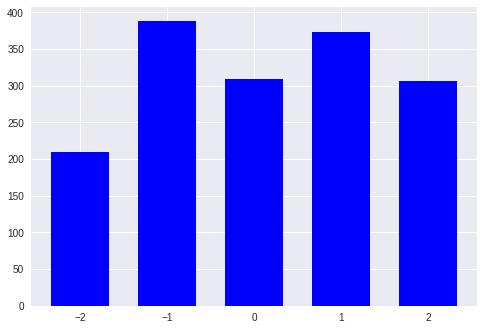

In [149]:
N = len(sentiment_distribution)
x = range(-2, 3)
width = 1/1.5
plt.bar(x, sentiment_distribution, width, color="blue")
post_dist = sentiment_distribution
plt.show()

Pink: 4 days leading up to the SEC Form release  
Red: 5 days on and after the SEC Form release  
Teal: Window 9 days around the SEC Form release

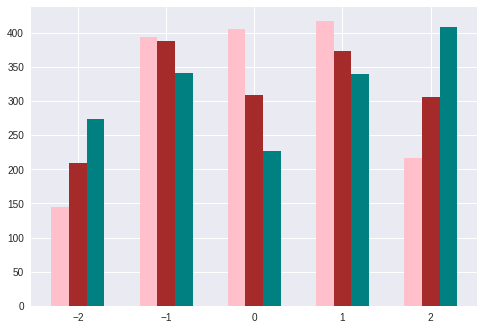

In [159]:
ax = plt.subplot(111)
width = 0.2
ax.bar(np.array(x)-0.2, pre_dist, width, color="pink")
ax.bar(np.array(x), post_dist, width, color="brown")
ax.bar(np.array(x)+0.2, window_dist, width, color="teal")
plt.show()

Just sampling or corporate conspiracy?

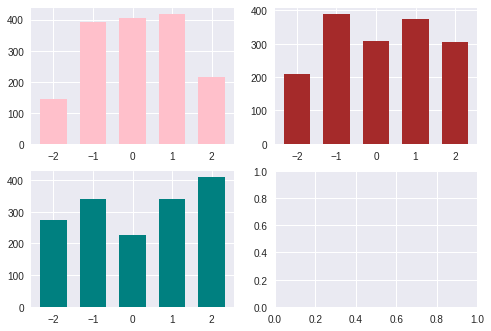

In [165]:
f, axes = plt.subplots(nrows=2, ncols=2)
width = 1.0/1.5
axes[0,0].bar(np.array(x), pre_dist, width, color="pink")
axes[0,1].bar(np.array(x), post_dist, width, color="brown")
axes[1,0].bar(np.array(x), window_dist, width, color="teal")
plt.show()